1. Скачиваем тестовое изображение

```
wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O /app/dataset/input.jpg
```

2. Экпорт mask-rcnn в torchscript

```
python /app/detectron2/tools/deploy/export_model.py \
    --format torchscript \
    --export-method tracing \
    --config-file /app/configs/custom_mask_rcnn_R_50_FPN_3x.yaml \
    --sample-image /app/dataset/input.jpg \
    --output /app/checkpoints/mask_rcnn_outputs
```

# PREPROC->MASK-RCNN->POSTPROC

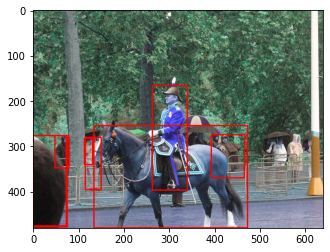

In [1]:
import argparse
from concurrent.futures import ThreadPoolExecutor, wait
import time
import tritonclient.http as httpclient
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2 
import matplotlib.pyplot as plt



def test_infer(req_id, image_file, model_name, print_output=False):
    with open(image_file, 'rb') as fi:
        image_bytes = fi.read()
    image_bytes = np.array([image_bytes], dtype=np.bytes_)
    # Define model's inputs
    inputs = []
    inputs.append(httpclient.InferInput('IMAGE_BYTES', image_bytes.shape, "BYTES"))
    inputs[0].set_data_from_numpy(image_bytes)
    # Define model's outputs
    outputs = []
    outputs.append(httpclient.InferRequestedOutput('BBOXES'))
    outputs.append(httpclient.InferRequestedOutput('CLASSES'))
    outputs.append(httpclient.InferRequestedOutput('MASKS'))
    outputs.append(httpclient.InferRequestedOutput('SCORES'))
    # Send request to Triton server
    triton_client = httpclient.InferenceServerClient(
        url="triton:8000", verbose=False)
    results = triton_client.infer(model_name, inputs=inputs, outputs=outputs)
    response_info = results.get_response()
    outputs = {}
    for output_info in response_info['outputs']:
        output_name = output_info['name']
        outputs[output_name] = results.as_numpy(output_name)

    if print_output:
        print(req_id, outputs)
    return outputs

image_file = '/app/dataset/test_imgs/input.jpg'
model_name = 'infer_pipeline'
n_reqs = 1
result = test_infer(0, image_file, model_name)



#VISUALIZE BBOXES
bboxes = result['BBOXES'].copy()
bboxes = bboxes.astype(int)
# Reading an image in default mode
image = cv2.imread(image_file)
for bbox in bboxes:
    start_point = (bbox[0], bbox[1])
    end_point = (bbox[2], bbox[3])
    # Blue color in BGR
    color = (255, 0, 0)
    # Line thickness of 2 px
    thickness = 2
    # Using cv2.rectangle() method
    # Draw a rectangle with blue line borders of thickness of 2 px
    image = cv2.rectangle(image, start_point, end_point, color, thickness)

# Displaying the image 
plt.imshow(image) 

# trained FASTER RCNN

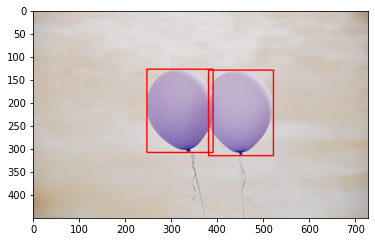

In [1]:
import argparse
from concurrent.futures import ThreadPoolExecutor, wait
import time
import tritonclient.http as httpclient
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2 

def test_infer(req_id, image_file, model_name, print_output=False):
    img = np.array(Image.open(image_file))
    img = np.ascontiguousarray(img.transpose(2, 0, 1))
    # Define model's inputs
    inputs = []
    inputs.append(httpclient.InferInput('image__0', img.shape, "UINT8"))
    inputs[0].set_data_from_numpy(img)
    # Define model's outputs
    outputs = []
    outputs.append(httpclient.InferRequestedOutput('bboxes__0'))
    outputs.append(httpclient.InferRequestedOutput('classes__1'))
    outputs.append(httpclient.InferRequestedOutput('scores__2'))
    outputs.append(httpclient.InferRequestedOutput('shape__3'))

    # Send request to Triton server
    triton_client = httpclient.InferenceServerClient(
        url="triton:8000", verbose=False)
    results = triton_client.infer(model_name, inputs=inputs, outputs=outputs)
    response_info = results.get_response()
    outputs = {}
    for output_info in response_info['outputs']:
        output_name = output_info['name']
        outputs[output_name] = results.as_numpy(output_name)
    return outputs

image_file = '/app/dataset/test_imgs/balloons.jpg'
model_name = 'faster_rcnn'
result = test_infer(0, image_file, model_name)


test_output = {'bboxes':[], 'classes': [], 'scores':[]}
for bbox, category, score in zip(result['bboxes__0'], result['classes__1'], result['scores__2']):
    if score > 0.9:
        test_output['bboxes'].append(bbox)
        test_output['classes'].append(category)
        test_output['scores'].append(score)
        
bboxes = test_output['bboxes'].copy()
# Reading an image in default mode
image = cv2.imread(image_file)
   
for bbox in bboxes:
    bbox = bbox.astype(int)
    start_point = (bbox[0], bbox[1])
    end_point = (bbox[2], bbox[3])
    # Blue color in BGR
    color = (255, 0, 0)
    # Line thickness of 2 px
    thickness = 2
    # Using cv2.rectangle() method
    # Draw a rectangle with blue line borders of thickness of 2 px
    image = cv2.rectangle(image, start_point, end_point, color, thickness)
  
# Displaying the image 
plt.imshow(image) 